# 学習方法の例

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle

In [3]:
import mlflow
import mlflow.sklearn

In [4]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# import pickle

# try:
#     from google.colab import files
#     print('Google Colab. 上での実行です')
#     print('「ファイルを選択」から、2_notebook/commonのlayers.pyを選択し、アップロードしてください')
#     print('===========')
#     files.upload()
#     !mkdir common
#     !mv *.py ./common
#     print('次に 1_dataのtrain_data.npy、train_label.npyを選択し、アップロードしてください')
#     print('===========')
#     files.upload()
#     !mkdir ../1_data
#     !mv *.npy ../1_data
# except:
#     print('ローカル環境での実行です')


# from common.layers import TwoLayerNet

## データを読む1

In [5]:
train_data = np.load("../1_data/train_data.npy")
train_label = np.load("../1_data/train_label.npy")
print("train_data.shape=", train_data.shape)
print("train_label.shape=", train_label.shape)

train_data.shape= (3000, 1, 28, 28)
train_label.shape= (3000, 15)


In [6]:
# 正規化
train_data = (train_data - train_data.min()) / train_data.max()
train_data = train_data.astype('float32')
# print(train_data)

In [7]:
# 配列形式変更
train_data = train_data.reshape(-1, 28*28)
print("train_data.shape=", train_data.shape)

train_data.shape= (3000, 784)


## trainとtestに分割する

In [8]:
X_train_all, X_test, y_train_all, y_test = train_test_split(train_data, train_label, 
                                                    test_size=0.3, random_state=1234,
                                                    shuffle=True
                                                   )

print(X_train_all.shape, X_test.shape)

(2100, 784) (900, 784)


In [9]:
# データを間引く
# X_train = X_train_all[:1000,:]
# y_train = y_train_all[:1000,:]
X_train = X_train_all
y_train = y_train_all
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2100, 784) (900, 784)
(2100, 15) (900, 15)


## 学習

In [10]:
# 勾配の比較方法。当面使わないので抜粋してコメントアウト
#             # 勾配の計算
#             grads = tnet.gradient(x_, y_)

#     #         # 勾配の比較（通常はコメントアウト）
#     #         # diffの値がほぼゼロであれば誤差逆伝播法が正しく実装できている
#     #         grad_numerical = tnet.numerical_gradient(x_, y_)
#     #         for key in grad_numerical.keys():
#     #             diff = np.average(np.abs(grads[key] - grad_numerical[key]))
#     #             print(key + ":" + str(diff))
    
#     #         break    


In [18]:
from common.layers import TwoLayerNet
def model_train(epochs, batch_size, lr):
    # 繰り返し回数
    xsize = X_train.shape[0]
    iter_num = np.ceil(xsize / batch_size).astype(int)

    # 2層NNのオブジェクト生成
    tnet = TwoLayerNet(input_size=28*28, hidden_size=10, output_size=15)

    train_loss = []; test_loss = []; train_accuracy = []; test_accuracy = []

    for epoch in range(epochs):
        if np.mod(epoch,10)==0 : print("**epoch=%s"%epoch)

        # シャッフル
        idx = np.arange(xsize)
        np.random.shuffle(idx)

        for it in range(iter_num):
            """
            ランダムなミニバッチを順番に取り出す
            """
            mask = idx[batch_size*it : batch_size*(it+1)]

            # ミニバッチの生成
            x_ = X_train[mask]
            y_ = y_train[mask]
            
            # 勾配の計算
            grads = tnet.gradient(x_, y_)

            # パラメータの更新
            for key in tnet.params.keys():
                tnet.params[key] -= lr * grads[key]

        # 訓練データおよびテストデータにおけるlossを記録
        train_loss.append(tnet.loss(X_train,  y_train)); test_loss.append(tnet.loss(X_test, y_test))

        # 訓練データおよびテストデータにおける精度を記録
        train_accuracy.append(tnet.accuracy(X_train, y_train)); test_accuracy.append(tnet.accuracy(X_test, y_test))
        
    return tnet, train_accuracy, test_accuracy, train_loss, test_loss

In [22]:
# mlflowなし
epochs = 40 #200
batch_size = 16#32
lr = 0.01

tnet, train_accuracy, test_accuracy, train_loss, test_loss = model_train(epochs, batch_size, lr)
print(test_accuracy[-1])
print(test_accuracy)

**epoch=0
**epoch=10
**epoch=20
**epoch=30
0.8122222222222222
[0.07, 0.06444444444444444, 0.10777777777777778, 0.17222222222222222, 0.25666666666666665, 0.32, 0.43, 0.43222222222222223, 0.5444444444444444, 0.5655555555555556, 0.5533333333333333, 0.6444444444444445, 0.5988888888888889, 0.6822222222222222, 0.6688888888888889, 0.7444444444444445, 0.6577777777777778, 0.7566666666666667, 0.8011111111111111, 0.71, 0.7711111111111111, 0.7711111111111111, 0.8177777777777778, 0.84, 0.8211111111111111, 0.7955555555555556, 0.7977777777777778, 0.7733333333333333, 0.8511111111111112, 0.7955555555555556, 0.81, 0.8444444444444444, 0.8322222222222222, 0.84, 0.74, 0.8477777777777777, 0.8111111111111111, 0.7777777777777778, 0.8155555555555556, 0.8122222222222222]


In [24]:
# mlflowに記録
epochs = 40 #200
batch_size = 16#32
lr = 0.01

# 管理IDを発行（コードの実行に対して）
experiment_id = 0
with mlflow.start_run(experiment_id=experiment_id):
    trial = 0

    tnet, train_acc, test_acc, train_loss, test_loss = model_train(epochs, batch_size, lr)

    # 小数点以下３桁まで出力
    print(f"trial {trial}: batch_size={batch_size}, lr={lr},　train_accuracy={train_acc[-1]:.3}, test_accuracy={test_acc[-1]:.3}")

    # ハイパーパラメータ, 評価指標, 学習済みモデルをMLflowへ保存
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("lr", lr)
    mlflow.log_metric("train_accuracy", train_accuracy[-1])
    mlflow.log_metric("test_accuracy", test_accuracy[-1])

    mlflow.sklearn.log_model(tnet, "model")

**epoch=0
**epoch=10
**epoch=20
**epoch=30
trial 0: batch_size=16, lr=0.01,　train_accuracy=0.856, test_accuracy=0.806


In [25]:
# mlflowに記録（グリッドサーチ）
# 管理IDを発行（コードの実行に対して）
experiment_id = 0
with mlflow.start_run(experiment_id=experiment_id):
    # ハイパーパラメータの試行水準
    cand_batch_size = [16, 32]
    cand_lr = [0.005, 0.01]

    trial = 0
    for batch_size in cand_batch_size:
        for lr in cand_lr:
            # 管理IDを発行（各パラメータ水準に対して）
            with mlflow.start_run(experiment_id=experiment_id, nested=True):
                trial += 1
                tnet, train_accuracy, test_accuracy, train_loss, test_loss = model_train(epochs, batch_size, lr)
                # model, mse, R2 = train(n_estimators, max_depth)
                # 小数点以下３桁まで出力
                print(f"trial {trial}: batch_size={batch_size}, lr={lr}, \
                      train_accuracy={train_accuracy[-1]:.3}, test_accuracy={test_accuracy[-1]:.3}")
                # 追加箇所
                # ハイパーパラメータ, 評価指標, 学習済みモデルをMLflowへ保存
                mlflow.log_param("batch_size", batch_size)
                mlflow.log_param("lr", lr)
                mlflow.log_metric("train_accuracy", train_accuracy[-1])
                mlflow.log_metric("test_accuracy", test_accuracy[-1])

                mlflow.sklearn.log_model(tnet, "model")


**epoch=0
**epoch=10
**epoch=20
**epoch=30
trial 1: batch_size=16, lr=0.005,                       train_accuracy=0.835, test_accuracy=0.817
**epoch=0
**epoch=10
**epoch=20
**epoch=30
trial 2: batch_size=16, lr=0.01,                       train_accuracy=0.898, test_accuracy=0.844
**epoch=0
**epoch=10
**epoch=20
**epoch=30
trial 3: batch_size=32, lr=0.005,                       train_accuracy=0.658, test_accuracy=0.649
**epoch=0
**epoch=10
**epoch=20
**epoch=30
trial 4: batch_size=32, lr=0.01,                       train_accuracy=0.845, test_accuracy=0.823


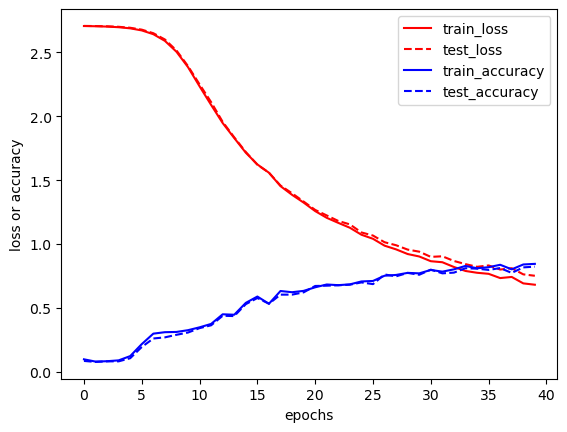

In [26]:
# lossのグラフ化
df_log = pd.DataFrame({"train_loss":train_loss,
             "test_loss":test_loss,
             "train_accuracy":train_accuracy,
             "test_accuracy":test_accuracy})
df_log.plot(style=['r-', 'r--', 'b-', 'b--'])
plt.ylabel("loss or accuracy")
plt.xlabel("epochs")
plt.show()

## 学習済みモデルの出力

In [16]:
with open("katakana_model.pickle", "wb") as f:
    pickle.dump(tnet, f)

- Google Colab. を使用している人は `katakana_model.pickle` のダウンロードを忘れないようにしよう
  - 「識別精度算出ウェブサイト」への投稿に必要な情報であるため
  - ファイルダウンロードの参考：https://blog.kikagaku.co.jp/google-colab-file#_Google_Colab